## Differential Drive Controller

Give the velocity V and the angular velocity $\omega$ from a twist message (we only consider linear.x and angular.x and ignore all other components) we can calculate the angular velocity of each wheel as follows:

We know
$$
\omega (R + b/2) = V_r
$$
$$
V_r = r\omega_r
$$
$$
V = R\omega
$$
where $\omega_r$ is the angular velocity of right wheel

Whith this we obtain
$$
\omega_r = \frac{V+\omega b/2}{r}
$$

and with
$$
\omega (R - b/2) = V_l
$$
we obtain
$$
\omega_l = \frac{V-\omega b/2}{r}
$$

### Converting ROS twist message to wheel speeds

The twist message uses m/s for linear velocity units and radians/s for the angular velocity units. We only consider the x component of the linear speed and the z component of the angular speed.

Assume $linerar_x$ in the range of -1 .. 1 and $angular_z$ in the range of -1 .. 1

$$
V = linerar_x
$$
$$
\omega = angular_z
$$

With this we obtain:
$$
\omega_r = \frac{linerar_x + angular_z b/2}{r}
$$
$$
\omega_l = \frac{linerar_x - angular_z b/2}{r}
$$


In [55]:
r = 0.0825
b = 0.18
b = 2

In [56]:
def get_wheel_speed(msg):
    l_x = msg['linear']['x']
    w = msg['angular']['z']
    w_r = (l_x + (b/2) * w) / r
    w_l = (l_x - (b/2) * w) / r
    return w_l, w_r

In [57]:
msg = {'linear': {'x': 1.0, 'y': 0.0, 'z': 0.0}, 'angular': {'x': 0.0, 'y': 0.0, 'z': 0.0}}
get_wheel_speed(msg)

(12.121212121212121, 12.121212121212121)

In [58]:
for i in range(11):
    for k in range(11):
        msg['linear']['x'] = i/10
        msg['angular']['z'] = k/10
        w_l, w_r = get_wheel_speed(msg)
        print("%.2f %.2f %s %s" % (i/10, k/10, int(w_l), int(w_r)))

0.00 0.00 0 0
0.00 0.10 -1 1
0.00 0.20 -2 2
0.00 0.30 -3 3
0.00 0.40 -4 4
0.00 0.50 -6 6
0.00 0.60 -7 7
0.00 0.70 -8 8
0.00 0.80 -9 9
0.00 0.90 -10 10
0.00 1.00 -12 12
0.10 0.00 1 1
0.10 0.10 0 2
0.10 0.20 -1 3
0.10 0.30 -2 4
0.10 0.40 -3 6
0.10 0.50 -4 7
0.10 0.60 -6 8
0.10 0.70 -7 9
0.10 0.80 -8 10
0.10 0.90 -9 12
0.10 1.00 -10 13
0.20 0.00 2 2
0.20 0.10 1 3
0.20 0.20 0 4
0.20 0.30 -1 6
0.20 0.40 -2 7
0.20 0.50 -3 8
0.20 0.60 -4 9
0.20 0.70 -6 10
0.20 0.80 -7 12
0.20 0.90 -8 13
0.20 1.00 -9 14
0.30 0.00 3 3
0.30 0.10 2 4
0.30 0.20 1 6
0.30 0.30 0 7
0.30 0.40 -1 8
0.30 0.50 -2 9
0.30 0.60 -3 10
0.30 0.70 -4 12
0.30 0.80 -6 13
0.30 0.90 -7 14
0.30 1.00 -8 15
0.40 0.00 4 4
0.40 0.10 3 6
0.40 0.20 2 7
0.40 0.30 1 8
0.40 0.40 0 9
0.40 0.50 -1 10
0.40 0.60 -2 12
0.40 0.70 -3 13
0.40 0.80 -4 14
0.40 0.90 -6 15
0.40 1.00 -7 16
0.50 0.00 6 6
0.50 0.10 4 7
0.50 0.20 3 8
0.50 0.30 2 9
0.50 0.40 1 10
0.50 0.50 0 12
0.50 0.60 -1 13
0.50 0.70 -2 14
0.50 0.80 -3 15
0.50 0.90 -4 16
0.50 1.00 -6 18
0

### Converting Hoverboard Feedback to Odometry message

Reading $\omega_r$ and $\omega_l$ from the hoverboard we need to construct a odometry message. As a matter of fact we read the speed of each wheel but knowing the radius of the wheel we can calculate the angular speed of the wheel.

Using:

$$
\omega_r = \frac{linerar_x + angular_z b/2}{r}
$$
$$
\omega_l = \frac{linerar_x - angular_z b/2}{r}
$$

we obtain:
$$
linerar_x = \frac{r \cdot (\omega_r + \omega_l )}{2}
$$
$$
angular_z = \frac{r \cdot (\omega_r - \omega_l )}{b}
$$


As a next step we have to calculate the position and orientation at time $\Delta$t given the position and orientation at time t.

$$
x(t_0) = 0
$$
$$
y(t_0) = 0
$$
$$
\Theta(t_0) = 0
$$
$$
t_{n+1} = t_n + \Delta t
$$
$$
x(t_{n+1}) = x(t_n) + h(v_l(t_n) + v_r(t_n))cos(\Theta(t)
$$
$$
y(t_{n+1}) = y(t_n) + h(v_l(t_n) + v_r(t_n))sin(\Theta(t)
$$
$$
\Theta(t_{n+1}) =\Theta(t_n) + h(v_r(t) - v_l(t)
$$
where $h = t_{n+1} - t_n$


And to calculate a quaternion from $\Theta$:

$$
q_w = cos(\Theta/2)
$$
$$
q_z = 0
$$
$$q_y = 0
$$
$$q_z = sin(\Theta/2)
$$



In [59]:
import numpy as np
import quaternion

In [60]:
def get_pose(x0, y0, Theta0, v_r, v_l, delta_t):
    Theta1 = Theta0 + delta_t * (v_r - v_l)
    x1 = x0 + delta_t * (v_r + v_l) * np.cos(Theta1/2)
    y1 = y0 + delta_t * (v_r + v_l) * np.sin(Theta1/2)
    q1 = np.quaternion(np.cos(Theta1/2), 0, 0, np.sin(Theta1/2))
    return x1, y1, Theta1, q1

In [61]:
delta_t = 1/20
v_r = 1.
v_l = -1.
x_n = 0.
y_n = 0.
Theta_n = 0.
for i in range(10):
    x_n, y_n, Theta_n, q = get_pose(x_n, y_n, Theta_n, v_r, v_l, delta_t)
    print("x: %.2f y: %.2f q: %s" % (x_n, y_n, q))

x: 0.00 y: 0.00 q: quaternion(0.998750260394966, 0, 0, 0.0499791692706783)
x: 0.00 y: 0.00 q: quaternion(0.995004165278026, 0, 0, 0.0998334166468282)
x: 0.00 y: 0.00 q: quaternion(0.988771077936042, 0, 0, 0.149438132473599)
x: 0.00 y: 0.00 q: quaternion(0.980066577841242, 0, 0, 0.198669330795061)
x: 0.00 y: 0.00 q: quaternion(0.968912421710645, 0, 0, 0.247403959254523)
x: 0.00 y: 0.00 q: quaternion(0.955336489125606, 0, 0, 0.29552020666134)
x: 0.00 y: 0.00 q: quaternion(0.939372712847379, 0, 0, 0.342897807455451)
x: 0.00 y: 0.00 q: quaternion(0.921060994002885, 0, 0, 0.38941834230865)
x: 0.00 y: 0.00 q: quaternion(0.900447102352677, 0, 0, 0.43496553411123)
x: 0.00 y: 0.00 q: quaternion(0.877582561890373, 0, 0, 0.479425538604203)


In [68]:
q.w

0.8775825618903728

### Applying Limits

We receive velocity (linear and angular), the time derivate of velocity is acceleration and the time derivate of acceleration is called jerk or jolt. To provide for a smooth movement of the robot we must apply limits to the velocity and the acceleration. At any time t the following contraints apply:

$$
v_{min} \le v(t) \le v_{max}
$$
$$
a_{min} \le \dot{v}(t) \le a_{max}
$$
$$
j_{min} \le \ddot{v}(t) \le j_{max}
$$

To solve $\ddot{v}$ numerically we need three data point $v_n$, $v_{n-1}$ and $v_{n-2}$

In [62]:
v_limit = 1.0
a_limit = 0.5
j_limit = 0.1
v_min = -v_limit
v_max = v_limit
a_min = -a_limit
a_max = a_limit
j_min = -j_limit
j_max = j_limit

In [63]:
def speed_limit(v_n, v_n1,v_n2, dt):
    a1 = (v_n - v_n1) / dt
    a2 = (v_n1 - v_n2) / dt
    a1 = min(a1, a_max)
    a2 = min(a2, a_max)
    a1 = max(a1, a_min)
    a2 = max(a2, a_min)
    j = (a1 - a2) / dt
    j = max(j, j_min)
    j = max(j, j_min)
    v = 2 * v_n1 - v_n2 + j * dt**2
    v = max(v, v_min)
    v = min(v, v_max)
    return v

In [64]:
v = [0., 0., 0.5, 1., 1.5, 2, 2, 2, 2, 2, 2, 2, 2, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

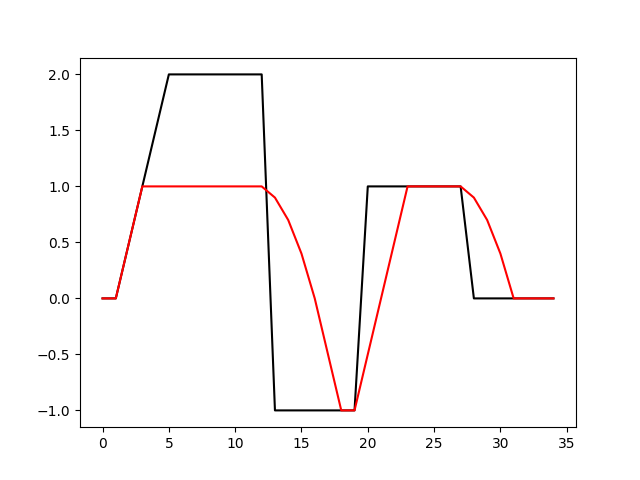

In [66]:
x = range(len(v))
v_lim = v[0:2]
a = [0]
j = [0]
for i in range(len(v)-2):
    v_lim.append(speed_limit(v[i+2], v_lim[i+1], v_lim[i], 1))
for i in range(len(v)-1):
    a.append(v_lim[i+1]-v_lim[i])
for i in range(len(v)-1):
    j.append(a[i+1]-a[i])
fig, ax = plt.subplots()
ax.plot(x, v, 'k')
#ax.plot(x, j, 'g')
ax.plot(x, v_lim, 'r')